In [1]:
!pip3 install torch torchvision

In [0]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# EDA

## DataLoader

In [0]:
batch_size = 1

In [0]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(mean=(0.5,), std=(0.5,))
                   ])),
    batch_size=batch_size,
    shuffle=True)

## Check data

In [0]:
images, labels = next(iter(train_loader))

In [6]:
images.shape, labels.shape # [batch_size, channel_size, h, w], [batch_size]

(torch.Size([1, 1, 28, 28]), torch.Size([1]))

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
images[0].shape # [channel, h, w]

torch.Size([1, 28, 28])

In [9]:
torch_image = torch.squeeze(images[0]) # remove useless dimension by squeeze()
torch_image.shape

torch.Size([28, 28])

In [10]:
image = torch_image.numpy()
image.shape

(28, 28)

In [11]:
label = labels[0].numpy()
label.shape, label.item()

((), 9)

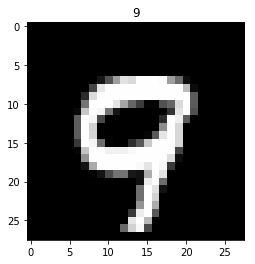

In [12]:
plt.title(label)
plt.imshow(image, 'gray')
plt.show()

# Layers explain

## Feature extraction

### Conv2d

In [13]:
conv_layer = nn.Conv2d(in_channels=1,
                       out_channels=20,
                       kernel_size=(5, 5),
                       stride=1).to(torch.device('cpu'))
conv_layer

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [14]:
weight = conv_layer.weight
weight.shape # [channel_size, kernal_h, kernal_w]

torch.Size([20, 1, 5, 5])

In [0]:
weight = weight.detach().numpy() # need to detach since ...

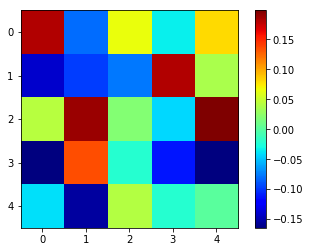

In [16]:
plt.imshow(weight[0, 0, :, :], 'jet')
plt.colorbar()
plt.show()

In [17]:
conv_output = conv_layer(images)
conv_output.shape # [batch_size, channel_size, kernal_h, kernal_w]

torch.Size([1, 20, 24, 24])

In [18]:
image_arr = images.numpy()
image_arr.shape

(1, 1, 28, 28)

In [19]:
conv_output_data = conv_output.data
output = conv_output_data.cpu().numpy()  # ...
output.shape

(1, 20, 24, 24)

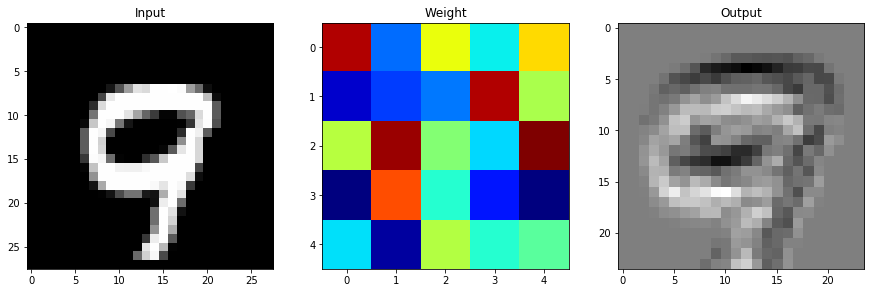

In [20]:
plt.figure(figsize=(15, 30))
plt.subplot(131)
plt.title('Input')
plt.imshow(np.squeeze(image_arr), 'gray')
plt.subplot(132)
plt.title('Weight')
plt.imshow(weight[0, 0, :, :], 'jet')
plt.subplot(133)
plt.title('Output')
plt.imshow(output[0, 0, :, :], 'gray')
plt.show()

### Pooling

In [21]:
pool_output = F.max_pool2d(conv_output, 2, 2)
pool_output.shape

torch.Size([1, 20, 12, 12])

In [22]:
conv_output_data = conv_output.data
output = conv_output_data.cpu().numpy()  # ...
output.shape

(1, 20, 24, 24)

In [23]:
pool_arr = pool_output.detach().numpy() # detach...
pool_arr.shape

(1, 20, 12, 12)

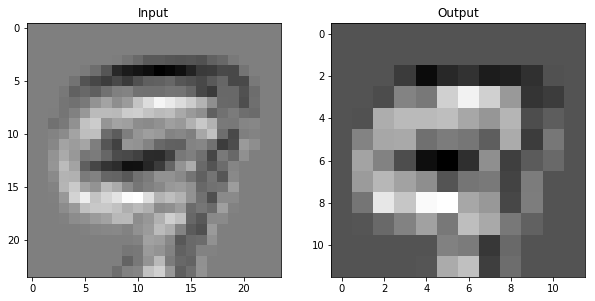

In [24]:
plt.figure(figsize=(10, 15))
plt.subplot(121)
plt.title("Input")
plt.imshow(np.squeeze(output[0, 0, :, :]), 'gray')
plt.subplot(122)
plt.title('Output')
plt.imshow(np.squeeze(pool_arr[0, 0, :, :]), 'gray')
plt.show()

## Classification

### Flatten

In [25]:
flatten_output = pool_output[0, 0, :, :].view(1, 12 * 12)
flatten_output.shape

torch.Size([1, 144])

### Linear

In [26]:
lin_output = nn.Linear(12*12, 10)(flatten_output)
lin_output.shape

torch.Size([1, 10])

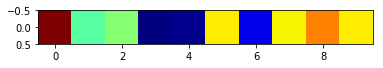

In [27]:
plt.imshow(lin_output.detach().numpy(), 'jet')
plt.show()

### Softmax

In [0]:
with torch.no_grad():
    flatten_output = pool_output[0, 0, :, :].view(1, 12*12)
    lin_output = nn.Linear(12*12, 10)(flatten_output)
    softmax_output = F.softmax(lin_output, dim=1)

In [29]:
softmax_output

tensor([[0.0793, 0.0940, 0.1145, 0.0809, 0.0903, 0.0902, 0.1142, 0.1234, 0.1064,
         0.1067]])

In [30]:
np.sum(softmax_output.numpy())

1.0

In [31]:
np.argmax(softmax_output)

tensor(7)

---

# Prepare dataset

In [0]:
seed = 1

batch_size = 64
test_batch_size = 64

no_cuda = False

In [0]:
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
torch.manual_seed(seed)

# load train dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

# load test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True)

In [0]:
# Build model

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        # Feature Extraction
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        # Fully Connected (Classficiation)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
model = Net().to(device)

## Optimizer

In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

In [39]:
model.train()  # train mode

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [40]:
data, target = next(iter(train_loader))
data.shape, target.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [41]:
data, target = data.to(device), target.to(device)
data.shape, target.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [0]:
optimizer.zero_grad()

In [0]:
output = model(data)

## Loss object

In [0]:
loss = F.nll_loss(output, target)

In [0]:
loss.backward()

In [0]:
optimizer.step()

In [0]:
epochs = 3
log_interval = 100

In [48]:
for epoch in range(1, epochs+1):
    # train mode
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # 1. init grad
        optimizer.zero_grad()
        # 2. forward
        output = model(data)
        # 3. calc loss
        loss = F.nll_loss(output, target)
        # 4. backprop
        loss.backward()
        # 5. update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100 * batch_idx / len(train_loader), loss.item()
            ))

    # eval        
    model.eval()

    test_loss = 0
    correct = 0
    with torch.no_grad(): # no_grad on eval mode
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.290735
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.228957
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.121072
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.893560
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.570058
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.213091
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.993894
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.778652
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.733029
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.624467

Test set: Average Loss: 0.4798, Accuracy: 8662/10000 (87%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.396035
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.490088
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.479047
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.301175
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.288177
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.553159
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.429490
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.406935
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.242401
T

In [49]:
model.eval() # eval mode

test_loss = 0
correct = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('\nTest set: Average Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))


Test set: Average Loss: 0.2269, Accuracy: 9322/10000 (93%)

